In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score

from sentence_transformers import SentenceTransformer, util

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load cleaned Shopee dataset provided by Member A
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/shopee_dataset_cleaned.csv")

# Quick check of dataset
df.head()

,posting_id,image,image_phash,title,label_group,title_clean,brand,category,title_norm,price,price_std
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,paper bag victoria secret,victoria secret,bag,paper bag victoria secret,60.030529,-0.164814
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,double tape 3m vhb 12 mm x 4 5 m original doub...,3m,stationery,double tape 3m vhb 12 mm x 4 5 m original doub...,8.037031,-0.527452
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,maling tts canned pork luncheon meat 397 gr,maling,food,maling tts canned pork luncheon meat 397 gr,15.687368,-0.474093
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,daster batik lengan pendek - motif acak campur...,pen,clothes,daster batik lengan pendek - motif acak campur...,43.957122,-0.276921
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,nescafe xc3 x89clair latte 220ml,nescafe,food,nescafe xc3 x89clair latte 220ml,3.101742,-0.561874


In [4]:
# Build TF-IDF vectorizer on cleaned titles
#tfidf = TfidfVectorizer(max_features=5000)
#df_sample = df.sample(2000, random_state=42).reset_index(drop=True)
#tfidf_matrix = tfidf.fit_transform(df_sample['title_clean'])

# Compute cosine similarity matrix
#cosine_sim_matrix = cosine_similarity(tfidf_matrix)

# Example: similarity between first 5 products
#cosine_sim_matrix[:5, :5]

In [5]:
# --- Step 1: Build TF-IDF matrix on full dataset ---
tfidf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf.fit_transform(df['title_clean'])

# --- Step 2: Convert image_phash (hex string) to integers ---
phash_int = df['image_phash'].apply(lambda x: int(x, 16)).to_numpy()

# --- Step 3: Define vectorized hamming distance ---
def hamming_distance_vec(arr1, arr2):
    # XOR and count bits
    return np.array([(arr1 ^ x).bit_count() for x in arr2])

# --- Step 4: Candidate generation by category ---
candidate_pairs = []
for cat in df['category'].unique():
    idx_cat = df.index[df['category'] == cat].to_numpy()
    phash_cat = phash_int[idx_cat]

    # Compute pairwise hamming distance (vectorized)
    for i in range(len(idx_cat)):
        dist = hamming_distance_vec(phash_cat[i], phash_cat[i+1:])
        # Select candidates with distance <= 10
        valid_idx = np.where(dist <= 10)[0]
        for j in valid_idx:
            candidate_pairs.append((idx_cat[i], idx_cat[i+1+j]))

print(f"Number of candidate pairs: {len(candidate_pairs)}")

Number of candidate pairs: 15554


In [6]:
# Define threshold for duplicate detection
threshold = 0.7

pred_pairs = []
true_labels = []
pred_labels = []

for (i, j) in candidate_pairs:
    sim = cosine_similarity(tfidf_matrix[i], tfidf_matrix[j])[0][0]
    pred = 1 if sim >= threshold else 0
    true = 1 if df.loc[i, 'label_group'] == df.loc[j, 'label_group'] else 0

    pred_pairs.append((df.loc[i, 'title'], df.loc[j, 'title'], sim, pred, true))
    pred_labels.append(pred)
    true_labels.append(true)

baseline_results = pd.DataFrame(pred_pairs, columns=['title1','title2','similarity','pred','true'])
baseline_results.head()

,title1,title2,similarity,pred,true
0,NEW ARRIVAL!! RANSEL BLACKPINK BTS KPOK TAS IM...,Blackpink K Pop Ransel BTS Dua Kali EXO Monsta...,0.171198,0,1
1,NEW ARRIVAL!! RANSEL BLACKPINK BTS KPOK TAS IM...,"b""Temukan BTS Dua Kali EXO Monsta X Mau Satu K...",0.172059,0,1
2,NEW ARRIVAL!! RANSEL BLACKPINK BTS KPOK TAS IM...,Tas Ransel BTS Hitam Pink Tosca Abu2,0.470815,0,1
3,[PERPACK] NON BRAND Kertas Buram / Kertas Kora...,NON BRAND Kertas Buram / Kertas Koran Uk. A4 -...,1.000000,1,1
4,HENGREDA Tas Pinggang Pria Waistbag Bahan Kuli...,[FST] Thodey Tas Pinggang Pria Waistbag Bahan ...,1.000000,1,1


In [7]:
# Evaluate baseline performance
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

print("TF-IDF + pHash (category grouped) Baseline Performance:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

TF-IDF + pHash (category grouped) Baseline Performance:
Precision: 0.9481
Recall: 0.4215
F1-score: 0.5836


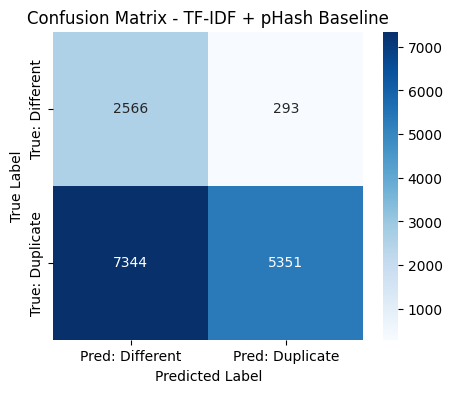

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Baseline confusion matrix ---
cm_baseline = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(5,4))
sns.heatmap(cm_baseline, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: Different", "Pred: Duplicate"],
            yticklabels=["True: Different", "True: Duplicate"])
plt.title("Confusion Matrix - TF-IDF + pHash Baseline")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [9]:
# Export TF-IDF baseline results to CSV
baseline_results.to_csv("/content/drive/My Drive/Colab Notebooks/baseline_results.csv", index=False)

# Export metrics to text file
with open("/content/drive/My Drive/Colab Notebooks/baseline_metrics.txt", "w") as f:
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1-score: {f1:.4f}\n")

print("TF-IDF baseline results and metrics exported.")

TF-IDF baseline results and metrics exported.


In [10]:
# Load multilingual Sentence-BERT model
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# Encode product titles
embeddings = model.encode(df['title_clean'].tolist(), batch_size=64, show_progress_bar=True)

# Save embeddings for later use
np.save("/content/drive/My Drive/Colab Notebooks/sentencebert_embeddings.npy", embeddings)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/536 [00:00<?, ?it/s]

In [11]:
# Compute cosine similarity using SBERT embeddings
#cosine_sim_matrix_sbert = util.cos_sim(embeddings, embeddings).cpu().numpy()

# Example: similarity between first 5 products
#cosine_sim_matrix_sbert[:5, :5]

In [12]:
# Candidate generation using pHash (same as before) ---
candidate_pairs = []
for cat in df['category'].unique():
    idx_cat = df.index[df['category'] == cat].to_numpy()
    phash_cat = phash_int[idx_cat]

    # Compute pairwise hamming distance (vectorized)
    for i in range(len(idx_cat)):
        dist = hamming_distance_vec(phash_cat[i], phash_cat[i+1:])
        # Select candidates with distance <= 10
        valid_idx = np.where(dist <= 10)[0]
        for j in valid_idx:
            candidate_pairs.append((idx_cat[i], idx_cat[i+1+j]))

print(f"Number of candidate pairs: {len(candidate_pairs)}")

Number of candidate pairs: 15554


In [13]:
# Duplicate detection with SBERT
threshold_sbert = 0.7

pred_pairs_sbert = []
true_labels_sbert = []
pred_labels_sbert = []

for (i, j) in candidate_pairs:
    sim = util.cos_sim(embeddings[i], embeddings[j]).item()
    pred = 1 if sim >= threshold_sbert else 0
    true = 1 if df.loc[i, 'label_group'] == df.loc[j, 'label_group'] else 0

    pred_pairs_sbert.append((df.loc[i, 'title'], df.loc[j, 'title'], sim, pred, true))
    pred_labels_sbert.append(pred)
    true_labels_sbert.append(true)

sentencebert_results = pd.DataFrame(pred_pairs_sbert, columns=['title1','title2','similarity','pred','true'])
sentencebert_results.head()

,title1,title2,similarity,pred,true
0,NEW ARRIVAL!! RANSEL BLACKPINK BTS KPOK TAS IM...,Blackpink K Pop Ransel BTS Dua Kali EXO Monsta...,0.384926,0,1
1,NEW ARRIVAL!! RANSEL BLACKPINK BTS KPOK TAS IM...,"b""Temukan BTS Dua Kali EXO Monsta X Mau Satu K...",0.364629,0,1
2,NEW ARRIVAL!! RANSEL BLACKPINK BTS KPOK TAS IM...,Tas Ransel BTS Hitam Pink Tosca Abu2,0.544230,0,1
3,[PERPACK] NON BRAND Kertas Buram / Kertas Kora...,NON BRAND Kertas Buram / Kertas Koran Uk. A4 -...,0.831260,1,1
4,HENGREDA Tas Pinggang Pria Waistbag Bahan Kuli...,[FST] Thodey Tas Pinggang Pria Waistbag Bahan ...,0.952773,1,1


In [14]:
# Evaluate SBERT performance
precision_sbert = precision_score(true_labels_sbert, pred_labels_sbert)
recall_sbert = recall_score(true_labels_sbert, pred_labels_sbert)
f1_sbert = f1_score(true_labels_sbert, pred_labels_sbert)

print("Sentence-BERT + pHash (category grouped) Performance:")
print(f"Precision: {precision_sbert:.4f}")
print(f"Recall: {recall_sbert:.4f}")
print(f"F1-score: {f1_sbert:.4f}")

Sentence-BERT + pHash (category grouped) Performance:
Precision: 0.9343
Recall: 0.6881
F1-score: 0.7925


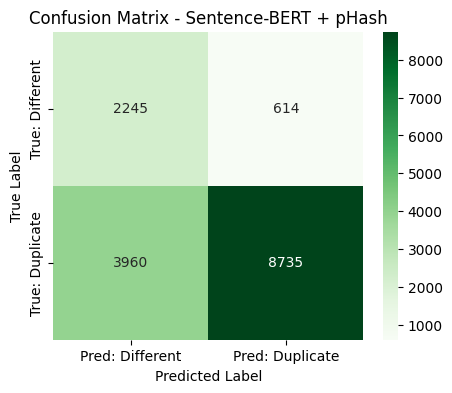

In [15]:
# --- SBERT confusion matrix ---
cm_sbert = confusion_matrix(true_labels_sbert, pred_labels_sbert)

plt.figure(figsize=(5,4))
sns.heatmap(cm_sbert, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Pred: Different", "Pred: Duplicate"],
            yticklabels=["True: Different", "True: Duplicate"])
plt.title("Confusion Matrix - Sentence-BERT + pHash")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [16]:
# Export Sentence-BERT results to CSV
sentencebert_results.to_csv("/content/drive/My Drive/Colab Notebooks/sentencebert_results.csv", index=False)

# Export metrics to text file
with open("/content/drive/My Drive/Colab Notebooks/sentencebert_metrics.txt", "w") as f:
    f.write(f"Precision: {precision_sbert:.4f}\n")
    f.write(f"Recall: {recall_sbert:.4f}\n")
    f.write(f"F1-score: {f1_sbert:.4f}\n")

print("Sentence-BERT results and metrics exported.")

Sentence-BERT results and metrics exported.


In [17]:
# Compare TF-IDF vs SBERT
results = pd.DataFrame({
    "Model": ["TF-IDF Baseline", "Sentence-BERT"],
    "Precision": [precision, precision_sbert],
    "Recall": [recall, recall_sbert],
    "F1-score": [f1, f1_sbert]
})

results

,Model,Precision,Recall,F1-score
0,TF-IDF Baseline,0.948086,0.421505,0.583565
1,Sentence-BERT,0.934325,0.688066,0.792506


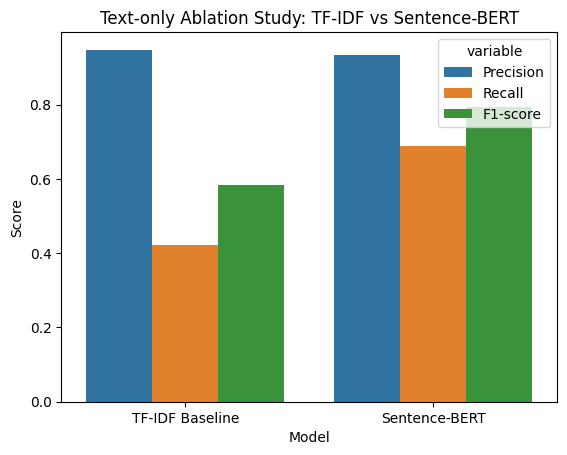

In [20]:
# Visualization of performance comparison
sns.barplot(data=results.melt(id_vars="Model"), x="Model", y="value", hue="variable")
plt.title("Text-only Ablation Study: TF-IDF vs Sentence-BERT")
plt.ylabel("Score")
plt.show()

Ablation Study table and figure exported.


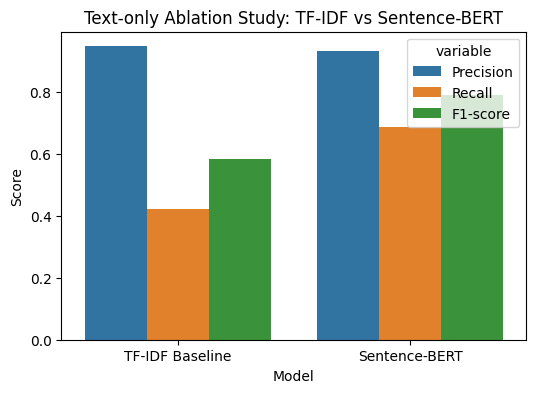

In [21]:
# Export Ablation Study comparison table to CSV
results.to_csv("/content/drive/My Drive/Colab Notebooks/ablation_textonly_table.csv", index=False)

# Save comparison figure
plt.figure(figsize=(6,4))
sns.barplot(data=results.melt(id_vars="Model"), x="Model", y="value", hue="variable")
plt.title("Text-only Ablation Study: TF-IDF vs Sentence-BERT")
plt.ylabel("Score")
plt.savefig("/content/drive/My Drive/Colab Notebooks/ablation_textonly_fig.png", dpi=300, bbox_inches="tight")

print("Ablation Study table and figure exported.")


Logistic Regression Performance:
Accuracy: 0.8939179632248939
Precision: 0.9068139963167587
Recall: 0.9696730996455297
F1-score: 0.9371907118385991

Random Forest Performance:
Accuracy: 0.9974926064034975
Precision: 0.9969373331239202
Recall: 1.0
F1-score: 0.9984663179834048


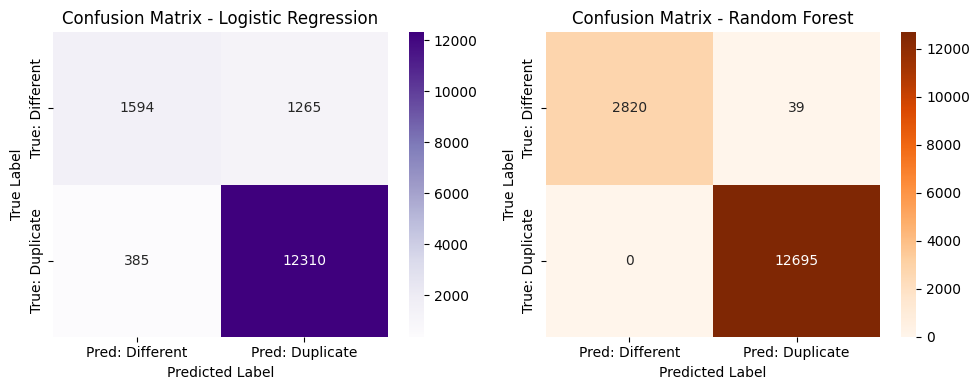

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# --- Step 6: Build training dataset for classifiers ---
X = []
y = []

for (i, j) in candidate_pairs:
    # Feature 1: SBERT similarity
    sim_sbert = util.cos_sim(embeddings[i], embeddings[j]).item()
    # Feature 2: TF-IDF similarity
    sim_tfidf = cosine_similarity(tfidf_matrix[i], tfidf_matrix[j])[0][0]
    # Label: whether they belong to the same group
    label = 1 if df.loc[i, 'label_group'] == df.loc[j, 'label_group'] else 0

    X.append([sim_sbert, sim_tfidf])
    y.append(label)

X = np.array(X)
y = np.array(y)

# --- Step 7: Train classifiers ---
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X, y)
y_pred_lr = lr.predict(X)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
y_pred_rf = rf.predict(X)

# --- Step 8: Evaluate classifiers ---
print("\nLogistic Regression Performance:")
print("Accuracy:", accuracy_score(y, y_pred_lr))
print("Precision:", precision_score(y, y_pred_lr))
print("Recall:", recall_score(y, y_pred_lr))
print("F1-score:", f1_score(y, y_pred_lr))

print("\nRandom Forest Performance:")
print("Accuracy:", accuracy_score(y, y_pred_rf))
print("Precision:", precision_score(y, y_pred_rf))
print("Recall:", recall_score(y, y_pred_rf))
print("F1-score:", f1_score(y, y_pred_rf))

# --- Step 9: Confusion matrices for classifiers ---
cm_lr = confusion_matrix(y, y_pred_lr)
cm_rf = confusion_matrix(y, y_pred_rf)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Pred: Different", "Pred: Duplicate"],
            yticklabels=["True: Different", "True: Duplicate"])
plt.title("Confusion Matrix - Logistic Regression")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

plt.subplot(1,2,2)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["Pred: Different", "Pred: Duplicate"],
            yticklabels=["True: Different", "True: Duplicate"])
plt.title("Confusion Matrix - Random Forest")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

plt.tight_layout()
plt.show()
